<a href="https://colab.research.google.com/github/t0mst0ne/earthquake/blob/main/Stephan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from xgboost import XGBClassifier
import graphviz
from sklearn.metrics  import precision_score, accuracy_score, confusion_matrix, f1_score, mean_squared_error
import matplotlib.pyplot as plt
import time


In [2]:
#df = pd.read_csv("output2.csv")
df = pd.read_csv('https://raw.githubusercontent.com/t0mst0ne/earthquake/main/output2.csv')


In [3]:
df.head(3)

,time,TEC,Dst,longitude,latitude,mag,depth
0,2013-01-01 00:00:00,22.71,4.0,0.0,0.0,0.0,0.0
1,2013-01-01 00:15:00,23.45,0.0,0.0,0.0,0.0,0.0
2,2013-01-01 00:30:00,24.22,0.0,0.0,0.0,0.0,0.0


In [4]:
import numpy as np

# 將 DataFrame 轉換為 NumPy 數組
tec_array = df['TEC'].values
dst_array = df['Dst'].values
mag_array = df['mag'].values

# 使用 NumPy 來構建 X 和 Y
X, Y = [], []
window_size = 1440
#for i in range(0, len(tec_array) - window_size):
for i in range(0, len(tec_array) - window_size):
    # 使用切片操作來構建 X
    tec_slice = tec_array[i:i + window_size]
    dst_slice = dst_array[i:i + window_size]
    X.append(np.concatenate([tec_slice, dst_slice]))

    # 構建 Y
    if mag_array[i + window_size] >= 5:
        Y.append(1)
    else:
        Y.append(0)

# 轉換 X 和 Y 為 NumPy 數組
X = np.array(X)
Y = np.array(Y)

# 打印信息
print(X[0])
print(X.shape)


[22.71 23.45 24.22 ...  0.    0.    0.  ]
(384907, 2880)


In [7]:
print( X[0:3] , Y[0:3])

[[22.71 23.45 24.22 ...  0.    0.    0.  ]
 [23.45 24.22 25.53 ...  0.    0.   -7.  ]
 [24.22 25.53 27.41 ...  0.   -7.    0.  ]] [0 0 0]


In [ ]:
# 保存到 CSV 文件

# 假設 X 和 Y 已經是 NumPy 數組
# 首先將 X 轉換為 DataFrame
X_df = pd.DataFrame(X)

# 將 Y 轉換為 DataFrame
Y_df = pd.DataFrame(Y, columns=['label'])

# 合併 X 和 Y
combined_df = pd.concat([X_df, Y_df], axis=1)

# 保存到 CSV 文件
combined_df.to_csv('data_1440_>0.csv', index=False)


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape)
import xgboost as xgb
num_neg = sum(Y_train == 0)
num_pos = sum(Y_train == 1)
scale_pos_weight = num_neg / num_pos
print("scale_pos_weight",scale_pos_weight)
# 創建DMatrix
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test, label=Y_test)

(269434, 2880)
scale_pos_weight 937.794425087108


[0]	train-logloss:0.67178	eval-logloss:0.67167
[1]	train-logloss:0.65557	eval-logloss:0.65582
[2]	train-logloss:0.64504	eval-logloss:0.64543
[3]	train-logloss:0.62706	eval-logloss:0.62716
[4]	train-logloss:0.60758	eval-logloss:0.60798
[5]	train-logloss:0.59588	eval-logloss:0.59610
[6]	train-logloss:0.58955	eval-logloss:0.58978
[7]	train-logloss:0.57900	eval-logloss:0.57915
[8]	train-logloss:0.57222	eval-logloss:0.57212
[9]	train-logloss:0.55688	eval-logloss:0.55711
[10]	train-logloss:0.55219	eval-logloss:0.55290
[11]	train-logloss:0.54254	eval-logloss:0.54337
[12]	train-logloss:0.53391	eval-logloss:0.53465
[13]	train-logloss:0.53011	eval-logloss:0.53087
[14]	train-logloss:0.52413	eval-logloss:0.52475
[15]	train-logloss:0.51684	eval-logloss:0.51726
[16]	train-logloss:0.51036	eval-logloss:0.51106
[17]	train-logloss:0.49982	eval-logloss:0.50057
[18]	train-logloss:0.48899	eval-logloss:0.49054
[19]	train-logloss:0.48273	eval-logloss:0.48434
[20]	train-logloss:0.47572	eval-logloss:0.47708
[2

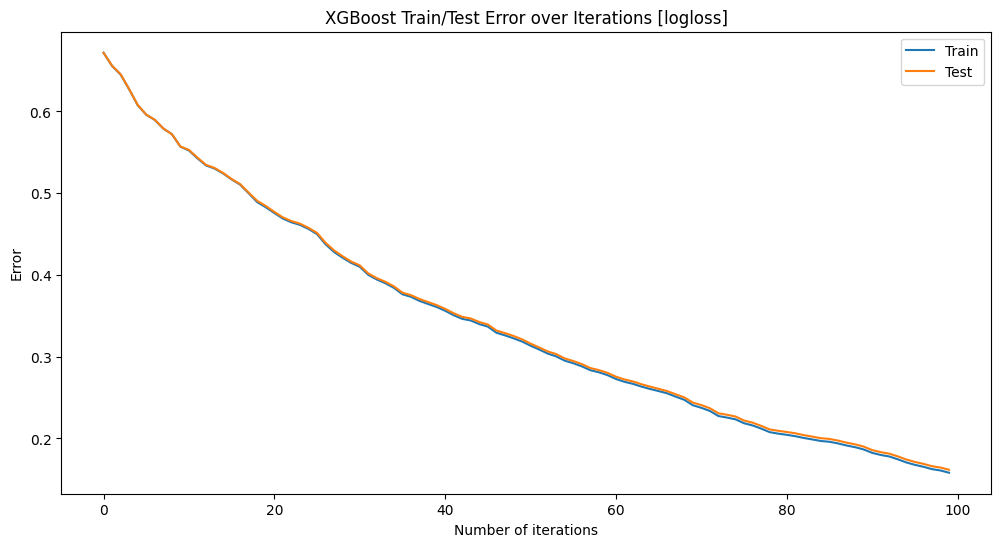

<Figure size 10000x8000 with 0 Axes>

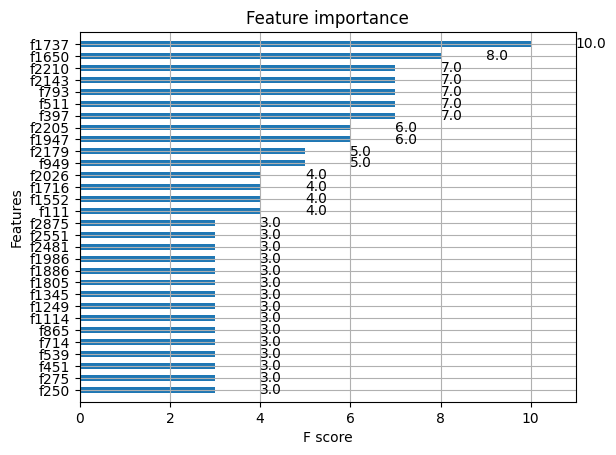

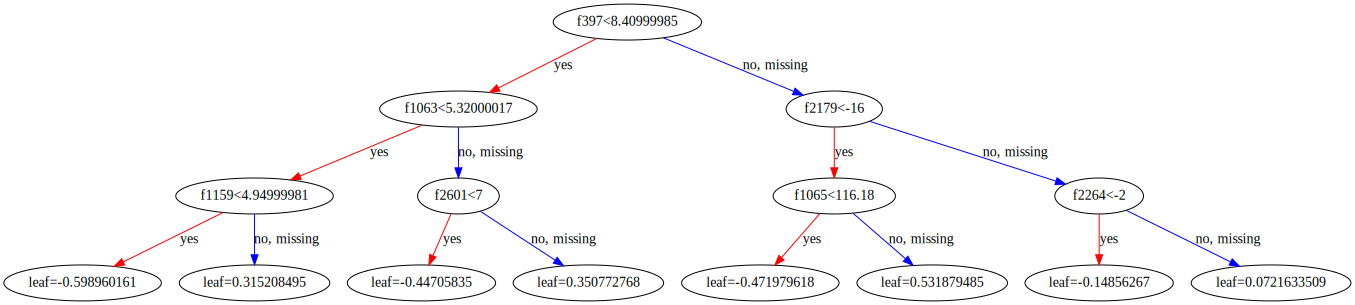

In [9]:

# 指定參數
params = {
    'max_depth': 3,  # 決定樹的深度
    'eta': 0.3,      # 學習率
    'objective': 'binary:logistic',
    'eval_metric': 'logloss' , # logloss作為評估指標,
#    'eval_metric': 'auc' , # auc 作為評估指標,
    'scale_pos_weight': scale_pos_weight ,
}

num_round = 100  # 訓練迭代的次數
early_stopping_rounds=50
eval_set = [(dtrain, 'train'), (dtest, 'eval')]

# 訓練模型
start = time.time()
evals_result = {}
bst = xgb.train(params, dtrain, num_round, evals=eval_set, early_stopping_rounds=early_stopping_rounds,evals_result=evals_result)
end = time.time()
print("訓練時間:", end - start)

#import xgboost as xgb
#import matplotlib.pyplot as plt


# 訓練和測試誤差曲線的繪製
train_error = evals_result['train']['logloss']  # 換成您的評估指標 logloss or auc
test_error = evals_result['eval']['logloss']  # 換成您的評估指標
epochs = len(train_error)
x_axis = range(0, epochs)

# 繪圖
plt.figure(figsize=(12,6))
plt.plot(x_axis, train_error, label='Train')
plt.plot(x_axis, test_error, label='Test')
plt.legend()

plt.ylabel('Error')
plt.xlabel('Number of iterations')
plt.title('XGBoost Train/Test Error over Iterations [logloss]')
plt.show()


plt.figure(figsize=(100, 80))  # 這裡10是寬度, 8是高度, 單位是英寸
#xgb.plot_importance(bst)
xgb.plot_importance(bst, importance_type='weight', max_num_features=30, height=0.5)
plt.rcParams['font.size'] = 8
plt.show()  # 顯示圖形
plt.savefig('feature_importance.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.close()  # 關閉圖形，避免再次顯示


xgb.to_graphviz(bst)


[0]	train-auc:0.62552	eval-auc:0.50554
[1]	train-auc:0.69313	eval-auc:0.53796
[2]	train-auc:0.72534	eval-auc:0.54246
[3]	train-auc:0.77197	eval-auc:0.53216
[4]	train-auc:0.81800	eval-auc:0.52984
[5]	train-auc:0.83743	eval-auc:0.52048
[6]	train-auc:0.84573	eval-auc:0.52100
[7]	train-auc:0.85882	eval-auc:0.52149
[8]	train-auc:0.86803	eval-auc:0.51753
[9]	train-auc:0.88641	eval-auc:0.52395
[10]	train-auc:0.89110	eval-auc:0.52076
[11]	train-auc:0.90294	eval-auc:0.52483
[12]	train-auc:0.90686	eval-auc:0.52487
[13]	train-auc:0.90924	eval-auc:0.52305
[14]	train-auc:0.91264	eval-auc:0.51670
[15]	train-auc:0.91803	eval-auc:0.51802
[16]	train-auc:0.92339	eval-auc:0.52170
[17]	train-auc:0.93229	eval-auc:0.52419
[18]	train-auc:0.93905	eval-auc:0.51239
[19]	train-auc:0.94048	eval-auc:0.51579
[20]	train-auc:0.94521	eval-auc:0.51865
[21]	train-auc:0.94855	eval-auc:0.51924
[22]	train-auc:0.95132	eval-auc:0.52287
[23]	train-auc:0.95303	eval-auc:0.51233
[24]	train-auc:0.95489	eval-auc:0.51388
[25]	train

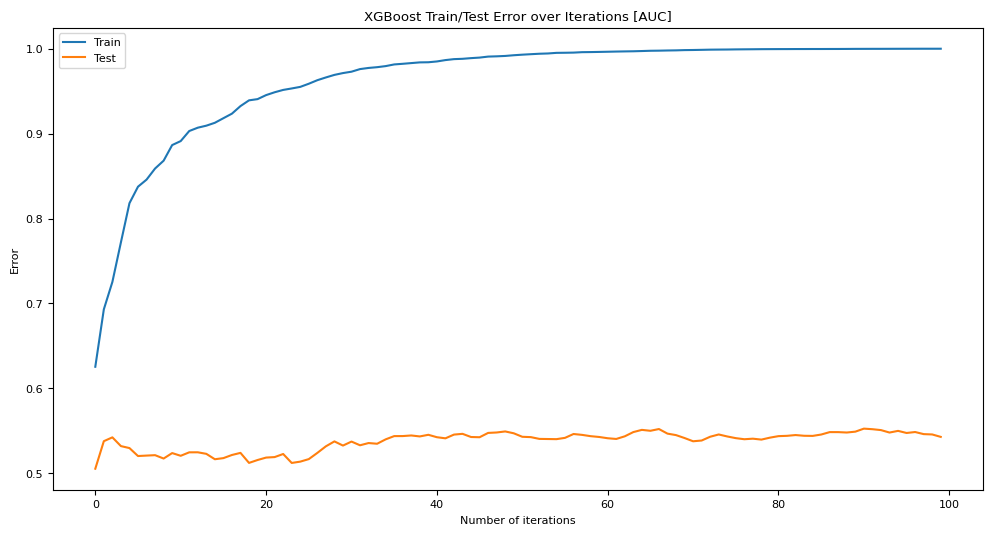

<Figure size 10000x8000 with 0 Axes>

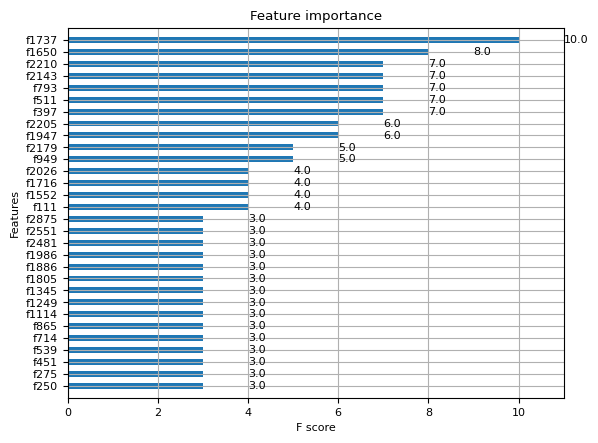

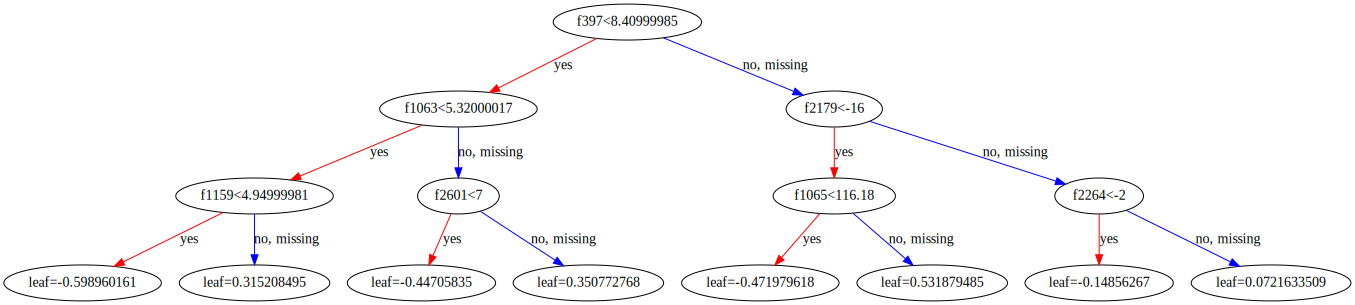

In [10]:
# 指定參數
params = {
    'max_depth': 3,  # 決定樹的深度
    'eta': 0.3,      # 學習率
    'objective': 'binary:logistic',
#    'eval_metric': 'logloss' , # logloss作為評估指標,
    'eval_metric': 'auc' , # auc 作為評估指標,
    'scale_pos_weight': scale_pos_weight ,
}

num_round = 100  # 訓練迭代的次數
early_stopping_rounds=50
eval_set = [(dtrain, 'train'), (dtest, 'eval')]

# 訓練模型
start = time.time()
evals_result = {}
bst = xgb.train(params, dtrain, num_round, evals=eval_set, early_stopping_rounds=early_stopping_rounds,evals_result=evals_result)
end = time.time()
print("訓練時間:", end - start)

#import xgboost as xgb
#import matplotlib.pyplot as plt


# 訓練和測試誤差曲線的繪製
train_error = evals_result['train']['auc']  # 換成您的評估指標 logloss or auc
test_error = evals_result['eval']['auc']  # 換成您的評估指標
epochs = len(train_error)
x_axis = range(0, epochs)

# 繪圖
plt.figure(figsize=(12,6))
plt.plot(x_axis, train_error, label='Train')
plt.plot(x_axis, test_error, label='Test')
plt.legend()

plt.ylabel('Error')
plt.xlabel('Number of iterations')
plt.title('XGBoost Train/Test Error over Iterations [AUC]')
plt.show()


plt.figure(figsize=(100, 80))  # 這裡10是寬度, 8是高度, 單位是英寸
#xgb.plot_importance(bst)
xgb.plot_importance(bst, importance_type='weight', max_num_features=30, height=0.5)
plt.rcParams['font.size'] = 8
plt.show()  # 顯示圖形
plt.savefig('feature_importance.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.close()  # 關閉圖形，避免再次顯示


xgb.to_graphviz(bst)

In [17]:
# 用測試數據評估模型
preds = bst.predict(dtest)

precision: 0.0021745883814849334
accuracy: 0.9711707498722645
F1: 0.004187855219862399


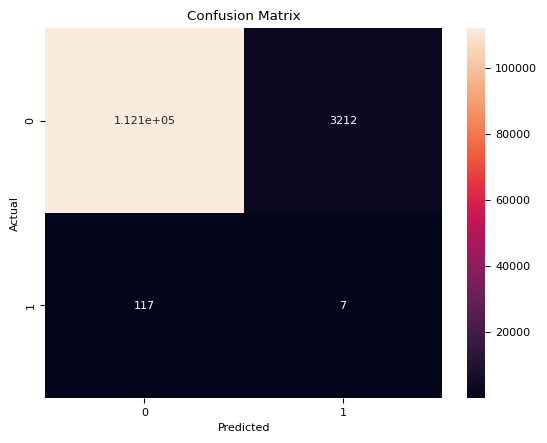

In [24]:
# 用測試數據評估模型
preds = bst.predict(dtest)

import seaborn as sns
# 假设 preds 是模型的预测结果，Y_test 是真实的标签
#mse = mean_squared_error(Y_test, preds)
#print("Mean Squared Error:", mse)


# Make predictions on the test set
y_pred = bst.predict(dtest)

# 將連續的目標變量轉換為二進制值
Y_test_binary = np.where(y_pred > 0.5, 1, 0)

# np.argmax 是多類用
#Y_test_binary = [np.argmax(prediction) for prediction in bst.predict(dtest)]


# 輸出結果
print("precision:", precision_score(Y_test, Y_test_binary))
print("accuracy:", accuracy_score(Y_test, Y_test_binary))
print("F1:", f1_score(Y_test, Y_test_binary))

conf_mat = confusion_matrix(Y_test, Y_test_binary)
ax = sns.heatmap(conf_mat, annot=True, fmt='.4g')
ax.set(ylabel="Actual", xlabel="Predicted", title="Confusion Matrix")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!cp '/content/data_1440_>0.csv' '/content/drive/MyDrive/Colab Notebooks/副本_share'

^C


In [22]:
y_pred

array([0.28250834, 0.0208854 , 0.30917084, ..., 0.3376281 , 0.04778305,
       0.09409124], dtype=float32)

In [ ]:
preds